**Modélisation de la consommation d'énergie**

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_row", 80)
pd.set_option("display.max_column", 80)

In [3]:
df = pd.read_csv('df_clean.csv', index_col=0)
print(df.shape)

# On ne garde qu'une seule target
target = 'SiteEnergyUseWN(kBtu)'
df = df.drop('TotalGHGEmissions', axis=1)

# On se débarasse des variables liées directement à nos target sauf 'SiteEUIWN(kBtu/sf)'
# que l'on va utiliser pour le train_test_split
df = df.drop(columns=['GHGEmissionsIntensity',
                      'SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)',
                     ])
print(df.shape)
df.head()

(1578, 17)
(1578, 12)


,Neighborhood,YearBuilt,NumberofFloors,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu)
0,DOWNTOWN,1927,12,Hotel,88434.0,None,0.0,None,0.0,60.0,84.300003,7456910.0
1,DOWNTOWN,1996,11,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,97.900002,8664479.0
2,DOWNTOWN,1969,41,Hotel,756493.0,None,0.0,None,0.0,43.0,97.699997,73937112.0
3,DOWNTOWN,1926,10,Hotel,61320.0,None,0.0,None,0.0,56.0,113.300003,6946800.5
4,DOWNTOWN,1980,18,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,118.699997,14656503.0


# Fonctions

## Réduction de catégories

In [4]:
def merge_property_types(df):
    """
    Fonction servant à regrouper des types d'usage des bâtiments pour réduire le 
    nombre de catégorie
    """
    
    # Attribution du type d'usage au cas par cas
    
    police = [2150, 2938, 2442, 234, 2680]
    df.loc[police, 'LargestPropertyUseType'] = 'Police Station'

    fire_stations = [100, 819, 3020, 3361, 3362, 3363]
    df.loc[fire_stations, 'LargestPropertyUseType'] = 'Fire Station'

    theatre = [70, 1280]
    df.loc[theatre, 'LargestPropertyUseType'] = 'Movie Theater'

    arts = [75]
    df.loc[arts, 'LargestPropertyUseType'] = 'Performing Arts'

    health = [1972]
    df.loc[health, 'LargestPropertyUseType'] = 'Fitness Center/Health Club/Gym'

    meeting_hall = [73, 195]
    df.loc[meeting_hall, 'LargestPropertyUseType'] = 'Social/Meeting Hall'

    laboratory = [303, 1255]
    df.loc[laboratory, 'LargestPropertyUseType'] = 'Laboratory'

    K12_school = [632]
    df.loc[K12_school, 'LargestPropertyUseType'] = 'K-12 School'

    distribution_center = [2140]
    df.loc[distribution_center, 'LargestPropertyUseType'] = 'Distribution Center'

    hosptial = [3182]
    df.loc[hosptial, 'LargestPropertyUseType'] = 'Hospital'
    
    supermarket = [506]
    df.loc[supermarket, 'LargestPropertyUseType'] = 'Supermarket/Grocery Store'
    
    restaurant = [1317]
    df.loc[restaurant, 'LargestPropertyUseType'] = 'Restaurant'
    
    other = [3019]
    df.loc[other, 'LargestPropertyUseType'] = 'Other'
    
    automobile = [3233]
    df.loc[automobile, 'LargestPropertyUseType'] = 'Automobile Dealership'
    
    
    # Regroupement des types d'usage
    
    for col in ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
        
        
        mask = ((df[col] == 'Small- and Mid-Sized Office')
                |(df[col] == 'Large Office')
                |(df[col] == 'Bank Branch')
                |(df[col] == 'Financial Office')
                |(df[col] == 'Police Station')
               )
        df.loc[mask, col] = 'Office'
        
        mask = ((df[col] == 'Movie Theater')
                | (df[col] == 'Museum')
                | (df[col] == 'Performing Arts'))
        df.loc[mask, col] = 'Entertainment/Public Assembly'

        mask = df[col] == 'Senior Care Community'
        df.loc[mask, col] = 'Residential Care Facility'

        mask = df[col] == 'Fitness Center/Health Club/Gym'
        df.loc[mask, col] = 'Recreation'

        mask = ((df[col] == 'Food Service')
               |(df[col] == 'Restaurant/Bar')
               |(df[col] == 'Fast Food Restaurant'))
        df.loc[mask, col] = 'Restaurant'

        mask = ((df[col] == 'Strip Mall')
               |(df[col] == 'Enclosed Mall'))
        df.loc[mask, col] = 'Mall'

        mask = ((df[col] == 'Distribution Center')
               |(df[col] == 'Non-Refrigerated Warehouse')
               |(df[col] == 'Wholesale Club/Supercenter'))
        df.loc[mask, col] = 'Warehouse'

        mask = ((df[col] == 'Specialty Hospital')
               |(df[col] == 'Urgent Care/Clinic/Outpatient')
               |(df[col] == 'Hospital (General Medical & Surgical)'))
        df.loc[mask, col] = 'Hospital'
        
        mask = ((df[col] == 'Convenience Store without Gas Station')
                |(df[col] == 'Food Sales'))
        df.loc[mask, col] = 'Supermarket/Grocery Store'

        mask = df[col] == 'Library'
        df.loc[mask, col] = 'Retail Store'
        
        mask = ((df[col] == 'Bar/Nightclub')
               |(df[col] == 'Vocational School')
               |(df[col] == 'Swimming Pool')
               |(df[col] == 'Technology/Science'))
        df.loc[mask, col] = 'Other'
        
    # Les types d'usages qui sont rares sont classés dans la catégorie 'Other',
    # sauf les 'Data Center' qui sont particuliers en raison de leur grande consommation
    # énergétique
    value_counts = df['LargestPropertyUseType'].value_counts()
    rare_classes = list(value_counts[value_counts < 5].index)
    for col in ['LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']:
        for val in rare_classes:
            if val == 'Data Center':
                continue
            df.loc[df[col] == val, col] = 'Other'

## Encodage

### Encodage OneHot

On va définir une fonction pour appliquer un OneHotEncoding modifié dans lequel on va tenir compte de la répartition des différents usages d'un bâtiment. On n'aura donc pas des valeurs binaires dans les colonnes catégorielles mais des pourcentages correspondant à la surface occupée par rapport à la surface totale du bâtiment.

In [5]:
def ohe_encoding(df):
    
    df_ = df.copy()
        
    # On définit une colonne correspondant à la surface totale
    df_['TotalGFA'] = (df_['LargestPropertyUseTypeGFA'] 
                       + df_['SecondLargestPropertyUseTypeGFA']
                       + df_['ThirdLargestPropertyUseTypeGFA'])

    # Encodage OneHot modifié
    for ind in df_.index:
        # usage principal
        prop_type = df_.loc[ind, 'LargestPropertyUseType']
        df_.loc[ind, prop_type] = df_.loc[ind, 'LargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']

        # usage secondaire
        sec_prop_type = df_.loc[ind, 'SecondLargestPropertyUseType']
        try: # Si la colonne existe déjà
            if np.isnan(df_.loc[ind, sec_prop_type]):
                df_.loc[ind, sec_prop_type] = df_.loc[ind, 'SecondLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
            else:
            # On utilise '+=' car il se peut que la case ait déjà été remplie si 'LargestPropertyUseTypeGFA'
            # et 'SecondLargestPropertyUseTypeGFA' sont du même type, et dans ce cas, on additionne les valeurs
                df_.loc[ind, sec_prop_type] += df_.loc[ind, 'SecondLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
        except KeyError:
            df_.loc[ind, sec_prop_type] = df_.loc[ind, 'SecondLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
            
        # usage tertiaire
        third_prop_type = df_.loc[ind, 'ThirdLargestPropertyUseType']
        try:
            if np.isnan(df_.loc[ind, third_prop_type]):
                df_.loc[ind, third_prop_type] = df_.loc[ind, 'ThirdLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
            else:
                df_.loc[ind, third_prop_type] += df_.loc[ind, 'ThirdLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']
        except KeyError:
            df_.loc[ind, third_prop_type] = df_.loc[ind, 'ThirdLargestPropertyUseTypeGFA'] / df_.loc[ind, 'TotalGFA']

    df_ = df_.drop('None', axis=1) # la colonne 'None' ne contient que des 0
    # on remplace les NaN par 0 dans les colonnes créées
    df_.loc[:, 'TotalGFA':] = df_.loc[:, 'TotalGFA':].fillna(0)

    # On retire les colonnes dont on n'a plus besoin
    columns = df_.loc[:, 'LargestPropertyUseType':'ThirdLargestPropertyUseTypeGFA'].columns
    df_ = df_.drop(columns=columns)

    # Encodage des autres variables catégorielles (Neighborhood)
    df_ = pd.get_dummies(df_)
    # On renomme les colonnes issues de ces variables
    columns = []
    for col in df_.columns:
        try:
            columns.append(col.split('_')[1])
        except IndexError:
            columns.append(col)
            continue
    df_.columns = columns
    
    return df_

On vérifie que le programme fonctionne correctement en vérifiant que la somme des valeurs des colonnes issues de l'encodage est égale à 1 pour toutes les lignes

In [6]:
df_ = df.copy()
merge_property_types(df_)
df_ = ohe_encoding(df_)
s = df_.loc[:, 'Hotel':'Manufacturing/Industrial Plant'].sum(axis=1)
s.unique()

array([1., 1., 1.])

### Target Encoding

Pour `TargetEncoder`, on va choisir des paramètres telle que la corrélation entre la target et les variables catégorielles soit faible pour éviter le "target leakage"

In [7]:
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

te = TargetEncoder(min_samples_leaf=30, smoothing=5)

df_ = df.dropna()
X_train, X_test, y_train, y_test = train_test_split(df_.drop(columns=target), df_[target], test_size=0.2, 
                                                    random_state=0)

X_train = te.fit_transform(X_train, y_train)
X_test = te.transform(X_test)

df_ = X_train.join(y_train)
for col in list(df.select_dtypes('object')):
    display(df_[[col, target]].corr())

,Neighborhood,SiteEnergyUseWN(kBtu)
Neighborhood,1.000000,0.151836
SiteEnergyUseWN(kBtu),0.151836,1.000000


,LargestPropertyUseType,SiteEnergyUseWN(kBtu)
LargestPropertyUseType,1.000000,0.192096
SiteEnergyUseWN(kBtu),0.192096,1.000000


,SecondLargestPropertyUseType,SiteEnergyUseWN(kBtu)
SecondLargestPropertyUseType,1.00000,0.17112
SiteEnergyUseWN(kBtu),0.17112,1.00000


,ThirdLargestPropertyUseType,SiteEnergyUseWN(kBtu)
ThirdLargestPropertyUseType,1.000000,0.201571
SiteEnergyUseWN(kBtu),0.201571,1.000000


In [8]:
def te_encoding(X_train, y_train, X_test):
    te = TargetEncoder(min_samples_leaf=30, smoothing=5)
    X_train = te.fit_transform(X_train, y_train)
    X_test = te.transform(X_test)
    return X_train, X_test

## Imputation des valeurs manquantes

In [9]:
def imputation(df, fill=False, label=None, value='median', columns=None):
    """
    Parameters
    ----------
    fill : boolean, default=False.
    
    label : None or object-type column name (str), default=None.
    
    value : 'median' or 'mean', default='median'.
    
    columns : None or list of strings, default=None
        List of columns to fill. If None, all columns containing NaN values will be filled.
    
    Returns
    ----------
    df_ : pandas DataFrame.
    """
    
    df_ = df.copy()
    
    if columns == None:
        mask = df_.columns.isin(df_.dropna(axis=1).columns)
        columns = df_.columns[~mask]
        
    if fill == False:
        df_ = df_.dropna()
        
    elif (fill == True and label != None):
        # On remplit les NaN en fonction de la valeur de label
        df_[columns] = df_[columns].fillna(df_.groupby(label)[columns].transform(value))
        # S'il reste de NaN, alors on les remplace tous par la même valeur
        if value == 'median':
            df_ = df_.fillna(df_.select_dtypes(np.number).median())
        elif value == 'mean':
            df_ = df_.fillna(df_.select_dtypes(np.number).mean())
            
    # Si label=None, on remplace directement tous les NaN par la même valeur
    elif (fill == True and label == None):
        if value == 'median':
            df_ = df_.fillna(df_.select_dtypes(np.number).median())
        elif value == 'mean':
            df_ = df_.fillna(df_.select_dtypes(np.number).mean())
            
    return df_

## Sélection de variables

In [10]:
from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_classif # use this for classification tasks
from sklearn.feature_selection import f_regression # use this for regression tasks
from sklearn.feature_selection import RFE

def feature_selection(X, y, model, n_features):    
    try:
        # Feature selection using Recursive Feature Elimimation (RFE)
        rfe = RFE(model, n_features_to_select=n_features)
        rfe.fit(X, y)
        selected_features = list(X.columns[rfe.support_])
        
    except ValueError:
        # Select Features by Strength of Relationship to Target
        kbest = SelectKBest(score_func=f_regression, k=n_features)
        kbest.fit(X, y)
        selected_features = list(X.columns[kbest.get_support()])
    
    return selected_features

## Évaluation

In [11]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [12]:
def evaluation(df, model, fill=False, label=None, value='median', columns=None, encoding='ohe', 
               log_scale=False, scaler=StandardScaler(), plot_learning_curve=False,
               figsize=(12, 8), hparams=None, scoring='r2', select_features=False, n_features=25,
               stratify=False, test_size=0.2, return_datasets=False, features_to_drop=[]):
    """
    Parameters
    ----------
    df : pandas DataFrame
        Data containing the features and the target.
    
    model : sklearn object type that implements the "fit" and "predict" methods
        
    fill : boolean, default=False
        Parameter of the `imputation` function.
    
    label : None or object-type column name (str), default=None
        Parameter of the `imputation` function.
    
    value : 'median' or 'mean', default='median'
        Parameter of the `imputation` function.
    
    columns : None or list of strings, default=None
        Parameter of the `imputation` function.
    
    encoding : str, 'le', 'ohe' or 'te', default='ohe'
    
    log_scale : boolean, default=False
        Whether to transform X into log(1+X) before scaling.
    
    scaler : Transformer
    
    plot_learning_curve : boolean, default=False
        
    figsize : (float, float), default=(12,8)
        Width, height in inches.
        
    hparams : dict or None, default=None
    
    scoring : 'r2', 'mae' or 'mse', default='r2'
    
    select_features : boolean, default=False
    
    n_features : int, default=25
    
    stratify : boolean, default=False
    
    test_size : float or int, default=0.2
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples.
        
    return_datasets : boolean, default=False
        If True returns X_train, X_test, y_train, y_test.
        
    features_to_drop : List of strings, empty by default
        List of features to drop before modelisation.
    
    Returns
    ----------
    
    """
    
    df_ = df.copy()
    df_ = df_.drop(columns=features_to_drop)
    
    # metrics for the scoring parameter
    metrics = {'r2': 'r2', 'mae': 'neg_mean_absolute_error', 'mse': 'neg_mean_squared_error'}
    
    
    # Pre-processing
    
    merge_property_types(df_)
    
    # Encodage et imputation
    if fill == True:
        df_ = imputation(df_, fill=fill, label=label, value=value, columns=columns)
    else:
        df_ = imputation(df_)
        
    property_types = df_['LargestPropertyUseType']
    
    if encoding == 'ohe': # OneHot Encoding
        df_ = ohe_encoding(df_)
    
    # Train/test split
    
    # On va essayer de répartir les bâtiments de manière homogène dans le train set
    # et le test set en utilisant la variable 'SiteEUIWN(kBtu/sf)'. Pour cela, on
    # va transformer les valeurs de cette variable en intervalles
    if (fill == True or df_.shape[0] == df.shape[0]):
        df_['SiteEUIWN(kBtu/sf)'] = pd.qcut(df_['SiteEUIWN(kBtu/sf)'], 150, duplicates='drop')
    else:
        df_['SiteEUIWN(kBtu/sf)'] = pd.qcut(df_['SiteEUIWN(kBtu/sf)'], 120, duplicates='drop')
    # On transforme les intervalles en eniers à l'aide d'un LabelEncoder
    le = LabelEncoder()
    df_['SiteEUIWN(kBtu/sf)'] = le.fit_transform(df_['SiteEUIWN(kBtu/sf)'])

    X = df_.drop(target, axis=1)
    y = df_[target]
    # Si stratify vaut True on transforme les valeurs de y en intervalles pour 
    # pouvoir utiliser le StratifiedKFold
    if stratify == True:
        le = LabelEncoder()
        if df_.shape[0] == df.shape[0]:
            y = le.fit_transform(pd.qcut(y, 250, duplicates='drop'))
        else:
            y = le.fit_transform(pd.qcut(y, 150, duplicates='drop'))
            
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, 
                                                       stratify=X['SiteEUIWN(kBtu/sf)'])
    X_train = X_train.drop('SiteEUIWN(kBtu/sf)', axis=1)
    X_test = X_test.drop('SiteEUIWN(kBtu/sf)', axis=1)
    
    # Target Encoding
    if encoding == 'te': # Target Encoding
        X_train, X_test = te_encoding(X_train, y_train, X_test)
        
    # Scaling
    if (log_scale == True and encoding == 'ohe'):
        columns = ['TotalGFA']
        X_train[columns] = np.log(1+X_train[columns])
        X_test[columns] = np.log(1+X_test[columns])
    elif (log_scale == True and encoding == 'te'):
        columns = ['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
                   'ThirdLargestPropertyUseTypeGFA']
        X_train[columns] = np.log(1+X_train[columns])
        X_test[columns] = np.log(1+X_test[columns])
        
    X_ = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_, columns=X_train.columns, index=X_train.index)
    X_ = scaler.transform(X_test)
    X_test = pd.DataFrame(X_, columns=X_test.columns, index=X_test.index)
    
    # Sélection de variables
    if select_features == True:
        selected_features = feature_selection(X_train, y_train, model, n_features=n_features)
        X_train, X_test = X_train[selected_features], X_test[selected_features]
    print('X_train shape :', X_train.shape)
    print('X_test shape :', X_test.shape)
    
        

    # Recherche des meilleurs hyperparamètres
    
    if hparams != None:
        # Create 5 folds
        seed = 13
        if stratify == False:
            kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
        else:
            kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        grid = GridSearchCV(estimator=model, param_grid=hparams, cv=kfold, scoring=metrics[scoring])
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        print('Grid best score:', grid.best_score_)
    print(model)
    
    
    
    #Cross-validation
    
    # Create 5 folds
    seed = 7
    if stratify == False:
        kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    else:
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    # Train and evaluate multiple models using kfolds
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=metrics['r2'])
    #print('CV results: ', results)
    print("CV Mean:", results.mean().round(3))
    print("CV Std:", results.std().round(3))
    
    
    
    # Modelisation of the test set

    # Fit model
    model.fit(X_train, y_train)
    # Evaluate model
    predictions = model.predict(X_test)
    print('test score :', r2_score(y_test, predictions).round(3))
    #print('MAE :', mean_absolute_error(y_test, predictions))
    #print('MSE :', mean_squared_error(y_test, predictions))
    
    
    
    # Learning curve
    if plot_learning_curve == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                   train_sizes=np.linspace(0.1, 1, 10), cv=5)
        plt.figure()
        plt.plot(N, train_score.mean(axis=1), label='train')
        plt.plot(N, val_score.mean(axis=1), label='validation')
        plt.title(type(model).__name__)
        plt.xlabel('train_sizes')
        plt.legend();
    

    if return_datasets == True:
        return X_train, X_test, y_train, y_test
            

# Modélisation

## KNeighborsRegressor

In [13]:
from sklearn.neighbors import KNeighborsRegressor

In [14]:
hparams_knr = [{'n_neighbors': np.arange(2, 15, 1), 
            'weights': ['uniform','distance']}]

model_knr = KNeighborsRegressor()

evaluation(df, model_knr, fill=True, label='Neighborhood', value='median', hparams=hparams_knr, encoding='ohe',
           select_features=True, n_features=20, log_scale=False,
           plot_learning_curve=False, test_size=.2)

X_train shape : (1262, 20)
X_test shape : (316, 20)
Grid best score: 0.5570556333168842
KNeighborsRegressor(n_neighbors=2, weights='distance')
CV Mean: 0.492
CV Std: 0.194
test score : 0.488


## SGDR

In [15]:
from sklearn.linear_model import SGDRegressor

X_train shape : (1262, 20)
X_test shape : (316, 20)
Grid best score: 0.5154336532547725
SGDRegressor(alpha=0.1, random_state=0)
CV Mean: 0.568
CV Std: 0.039
test score : 0.706


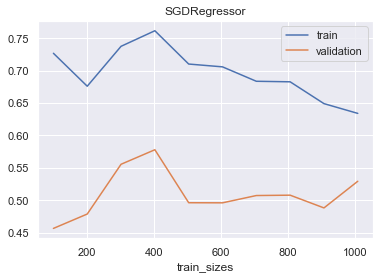

In [16]:
hparams_sgdr = {'penalty': ['l2', 'l1', 'elasticnet'], 
                'alpha': np.logspace(-4, 2, 7),
                #'tol': np.logspace(-3, -1, 3)
            }

model_sgdr = SGDRegressor(random_state=0)

evaluation(df, model_sgdr, fill=True, label='Neighborhood', value='median', 
           hparams=hparams_sgdr, encoding='ohe',
           select_features=True, n_features=20, log_scale=False,
           plot_learning_curve=True, test_size=.2)

## SVR

In [17]:
from sklearn.svm import SVR

X_train shape : (1262, 44)
X_test shape : (316, 44)
Grid best score: 0.4730498600267722
SVR(C=100000.0, kernel='linear')
CV Mean: 0.49
CV Std: 0.1
test score : 0.592


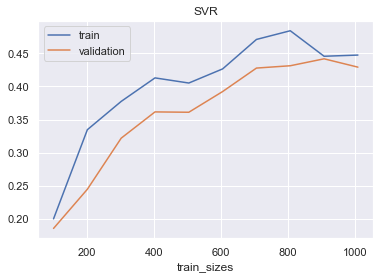

In [18]:
hparams_svr = {'kernel': ['linear', 'rbf'],
               #'gamma': ['auto', 'scale'],
               #'degree': [2,3,4,5],
               'C': [1e3, 1e4, 1e5],
               #'epsilon': np.logspace(-5, -1, 5)
              }

model_svr = SVR()

evaluation(df, model_svr, fill=True, label='Neighborhood', value='median', hparams=hparams_svr, encoding='ohe',
           select_features=False, n_features=20,
           plot_learning_curve=True, test_size=.2)

## KernelRidge

In [19]:
from sklearn.kernel_ridge import KernelRidge

X_train shape : (1262, 25)
X_test shape : (316, 25)
Grid best score: 0.7054412538469309
KernelRidge(alpha=1.0, degree=2, kernel='poly')
CV Mean: 0.688
CV Std: 0.127
test score : 0.729


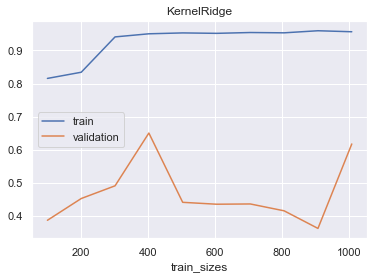

In [20]:
hparams_krr = {'alpha': np.logspace(-2, 2, 5),
               'kernel': ['poly', 'rbf'], 
               'degree': np.arange(2, 5, 1),
               #'gamma': np.logspace(-4, 0, 5)
              }

model_krr = KernelRidge()

evaluation(df, model_krr, fill=True, label='Neighborhood', value='median', hparams=hparams_krr, encoding='ohe',
           select_features=True, n_features=25, log_scale=False, 
           plot_learning_curve=True, test_size=.2)

## Random Forest

In [21]:
from sklearn.ensemble import RandomForestRegressor

X_train shape : (1262, 44)
X_test shape : (316, 44)
RandomForestRegressor(n_estimators=10, random_state=0)
CV Mean: 0.624
CV Std: 0.146
test score : 0.678


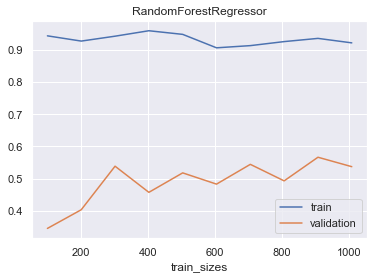

In [22]:
model_rfr = RandomForestRegressor(n_estimators=10, random_state=0)

evaluation(df, model_rfr, fill=True, label=None, value='median', hparams=None, encoding='ohe',
           select_features=False, n_features=20, log_scale=False,
           plot_learning_curve=True, test_size=.2)

## Voting

In [23]:
from sklearn.ensemble import VotingRegressor

X_train shape : (1262, 20)
X_test shape : (316, 20)
VotingRegressor(estimators=[('KNN',
                             KNeighborsRegressor(n_neighbors=4,
                                                 weights='distance')),
                            ('SGDR',
                             SGDRegressor(alpha=1.0, penalty='elasticnet',
                                          random_state=0)),
                            ('SVR', SVR(C=100000.0, kernel='linear')),
                            ('Kernel Ridge',
                             KernelRidge(alpha=0.01, degree=2, kernel='rbf')),
                            ('Random Forest',
                             RandomForestRegressor(random_state=0))])
CV Mean: 0.63
CV Std: 0.163
test score : 0.734


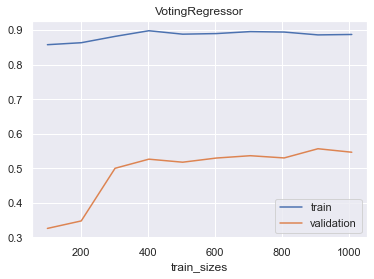

In [24]:
model_knr = KNeighborsRegressor(n_neighbors=4, weights='distance')
model_sgdr = SGDRegressor(alpha=1.0, penalty='elasticnet', random_state=0)
model_svr = SVR(C=1e5, kernel='linear')
model_krr = KernelRidge(alpha=0.01, degree=2, kernel='rbf')
model_rfr = RandomForestRegressor(random_state=0)

voting = VotingRegressor([('KNN', model_knr),
                         ('SGDR', model_sgdr),
                         ('SVR', model_svr),
                         ('Kernel Ridge', model_krr),
                         ('Random Forest', model_rfr)
                        ])

evaluation(df, voting, fill=True, label=None, value='median', hparams=None, encoding='ohe',
           select_features=True, n_features=20, 
           plot_learning_curve=True, test_size=.2)

## Bagging

In [25]:
from sklearn.ensemble import BaggingRegressor

X_train shape : (843, 39)
X_test shape : (211, 39)
BaggingRegressor(base_estimator=KernelRidge(alpha=0.1, degree=2, kernel='poly'),
                 n_estimators=30, random_state=0)
CV Mean: 0.695
CV Std: 0.144
test score : 0.69


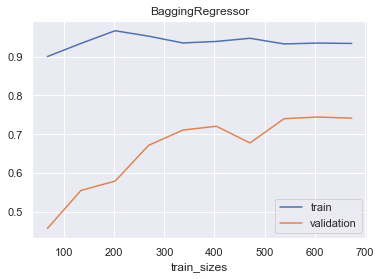

In [26]:
estimator = KernelRidge(alpha=0.1, degree=2, kernel='poly')
bagging = BaggingRegressor(base_estimator=estimator, n_estimators=30, random_state=0)

evaluation(df, bagging, fill=False, label=None, value='median', hparams=None, encoding='ohe',
           select_features=False, n_features=30, 
           plot_learning_curve=True, test_size=.2)

## Boosting

### AdaBoostRegressor

In [27]:
from sklearn.ensemble import AdaBoostRegressor

In [28]:
hparams_abr = {'n_estimators': [10, 50],
           'learning_rate': np.logspace(-2, 2, 5),
           'loss': ['linear', 'square']
          }

adaboost = AdaBoostRegressor(base_estimator=None, n_estimators=10, random_state=0)

evaluation(df, adaboost, fill=False, label=None, value='median', hparams=hparams_abr, encoding='ohe',
           select_features=False, n_features=25, 
           plot_learning_curve=False, test_size=.2)

X_train shape : (843, 39)
X_test shape : (211, 39)
Grid best score: 0.5752633645127003
AdaBoostRegressor(n_estimators=10, random_state=0)
CV Mean: 0.499
CV Std: 0.299
test score : 0.57


X_train shape : (843, 39)
X_test shape : (211, 39)
AdaBoostRegressor(base_estimator=KernelRidge(alpha=0.1, degree=2,
                                             kernel='poly'),
                  n_estimators=10, random_state=0)
CV Mean: 0.703
CV Std: 0.1
test score : 0.634


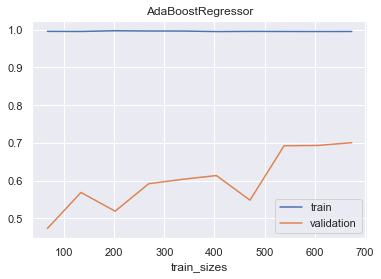

In [29]:
adaboost = AdaBoostRegressor(base_estimator=estimator, n_estimators=10, random_state=0)

evaluation(df, adaboost, fill=False, label=None, value='mean', hparams=None, encoding='ohe', 
           select_features=False, n_features=30, log_scale=False,
           plot_learning_curve=True, test_size=.2)

### Gradient Boosting

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
hparams_gbr = {'n_estimators': [10, 50, 100],
               'learning_rate': np.logspace(-3, 0, 4),
               'loss': ['squared_error', 'absolute_error'],
               #'max_depth': [2,3,4],
               #'min_samples_leaf': [3],
               #'tol': np.logspace(-6, -4, 3)
          }

model_gbr = GradientBoostingRegressor(random_state=0)

evaluation(df, model_gbr, fill=True, label='Neighborhood', value='median', hparams=hparams_gbr, encoding='ohe', 
           select_features=False, n_features=30, log_scale=False,
           plot_learning_curve=False, test_size=.2)

X_train shape : (1262, 44)
X_test shape : (316, 44)
Grid best score: 0.6090347075631969
GradientBoostingRegressor(learning_rate=1.0, loss='absolute_error',
                          n_estimators=50, random_state=0)
CV Mean: 0.594
CV Std: 0.103
test score : 0.346


# Fine tuning du meilleur modèle

X_train shape : (843, 39)
X_test shape : (211, 39)
Grid best score: 0.6010258596483314
BaggingRegressor(base_estimator=KernelRidge(alpha=0.01, degree=2,
                                            kernel='poly'),
                 n_estimators=50, random_state=0)
CV Mean: 0.738
CV Std: 0.13
test score : 0.764


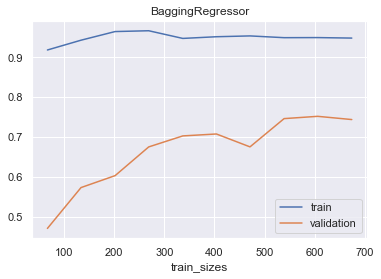

In [32]:
estimator = KernelRidge(alpha=0.01, degree=2, kernel='poly')
bagging = BaggingRegressor(base_estimator=estimator, n_estimators=20, random_state=0)

hparams_bag = {#'base_estimator__alpha': np.linspace(0.005, 0.015, 11),
               #'base_estimator__degree': [2, 3, 4],
               #'base_estimator__kernel': ['poly', 'rbf', 'laplacian', 'chi2', 'cosine'],
               'n_estimators': [40, 50, 60]
              }

evaluation(df, bagging, fill=False, label=None, value='median', hparams=hparams_bag, encoding='ohe',
           select_features=False, n_features=25,
           plot_learning_curve=True, test_size=.2)

# Feature importance

X_train shape : (843, 39)
X_test shape : (211, 39)
BaggingRegressor(base_estimator=KernelRidge(alpha=0.01, degree=2,
                                            kernel='poly'),
                 n_estimators=50, random_state=0)
CV Mean: 0.738
CV Std: 0.13
test score : 0.764


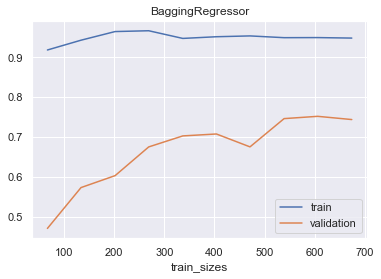

In [82]:
final_model = BaggingRegressor(base_estimator=KernelRidge(alpha=.01, degree=2, kernel='poly'),
                               n_estimators=50, random_state=0)

X_train, X_test, y_train, y_test = evaluation(df, final_model, fill=False, hparams=None, 
                                              encoding='ohe', select_features=False, n_features=30, 
                                              plot_learning_curve=True, test_size=.2, return_datasets=True)

In [83]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(843, 39) (843,)
(211, 39) (211,)


In [84]:
import shap
#shap.initjs()

## Compilation des shap values

La cellule qui suit va calculer les SHAP values. Le temps de calcul peut être relativement long donc si le code précédent n'a pas été modifié, vous pouvez importer les SHAP values sauvegardées dans ce répertoire comme indiqué dans la cellule d'après.

In [85]:
# background data
X_back = shap.utils.sample(X_train, 200)

final_model.fit(X_train, y_train)

explainer = shap.Explainer(final_model.predict, X_back)
shap_values = explainer(X_test)
shap_vals = shap_values.values
base_value = shap_values.base_values[0]

Permutation explainer: 212it [12:46,  3.67s/it]                         


```Python
# Pour sauvegarder les shap values
import pickle
with open('shap_values_target1_bagging', 'wb') as fichier:
    mon_pickler = pickle.Pickler(fichier)
    mon_pickler.dump(shap_values)

# Pour les importer
with open('shap_values_target1_bagging', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    shap_values = my_depickler.load()
```

On va évaluer la qualité des shap values en calculant le R$^2$ entre les valeurs prédites par le modèles et celles prédites par shap

In [37]:
# Valeurs prédites par le modèle
predictions = final_model.predict(X_test)

# Valeurs prédites à partir des shap values
shap_predictions = base_value + shap_vals.sum(axis=1)

# Somme des carrés résiduelle
SSR = ((predictions - shap_predictions)**2).sum()

# Somme des carrés totale
SST = ((predictions - predictions.mean())**2).sum()

R2 = 1 - SSR/SST
R2

1.0

Visualisation graphique

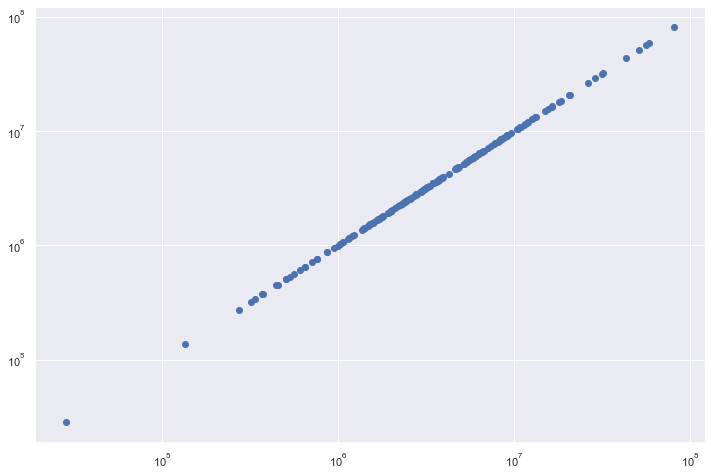

In [38]:
plt.figure(figsize=(12,8))
plt.scatter(predictions, shap_predictions)
plt.xscale('log')
plt.yscale('log')

Les valeurs prédites par le modèle et shap sont les mêmes

## Influence globale des variables

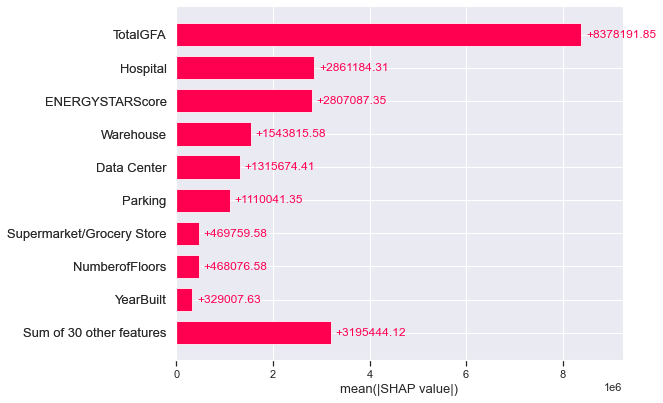

In [39]:
# Moyenne de la valeur absolue des shap values
shap.plots.bar(shap_values, max_display=10)

On remarque que l'ENERGYSTARScore figure parmis les variables les plus importantes.

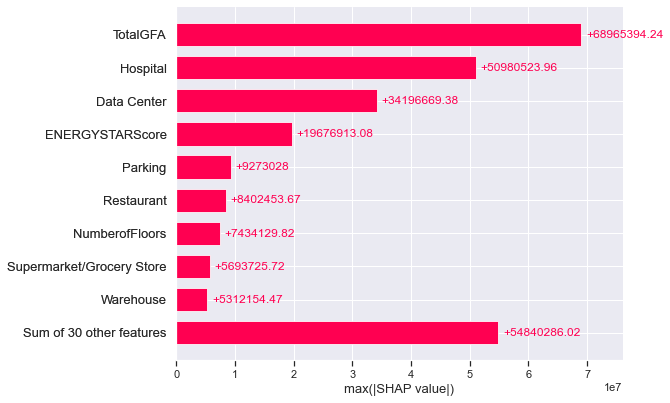

In [40]:
# Valeur maximale de la shap value en valeur absolue
shap.plots.bar(shap_values.abs.max(0))

## Influence locale

Prenons un bâtiment au hasard et regardons ses shap values

In [41]:
shap_ind = np.random.randint(0, shap_vals.shape[0])
ind = X_test.iloc[[shap_ind]].index
print(shap_ind)
print(ind.values)
df.loc[int(ind.values)]

121
[573]


Neighborhood                         DOWNTOWN
YearBuilt                                1998
NumberofFloors                             13
LargestPropertyUseType                 Office
LargestPropertyUseTypeGFA            145491.0
SecondLargestPropertyUseType          Parking
SecondLargestPropertyUseTypeGFA       70603.0
ThirdLargestPropertyUseType              None
ThirdLargestPropertyUseTypeGFA            0.0
ENERGYSTARScore                          25.0
SiteEUIWN(kBtu/sf)                 118.699997
SiteEnergyUseWN(kBtu)              17267470.0
Name: 573, dtype: object

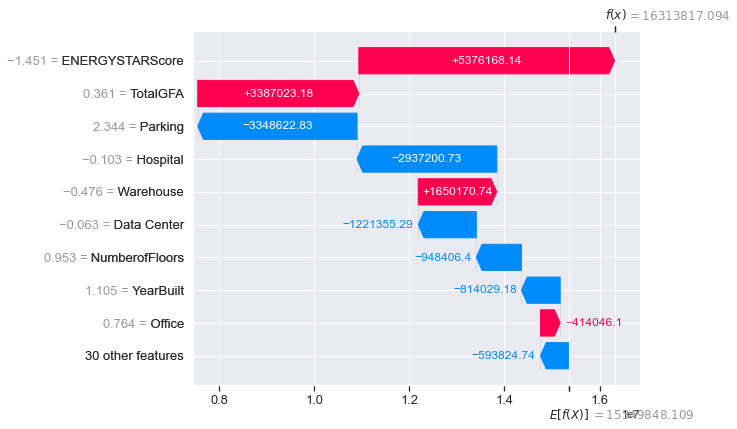

In [42]:
shap.plots.waterfall(shap_values[shap_ind])

On retrouve bien les caractéristiques du bâtiment (type d'usage et quartier) parmis les variables les plus importantes

Visualisons maintenant l'ensemble des shap values à l'aide d'un beeswarm plot

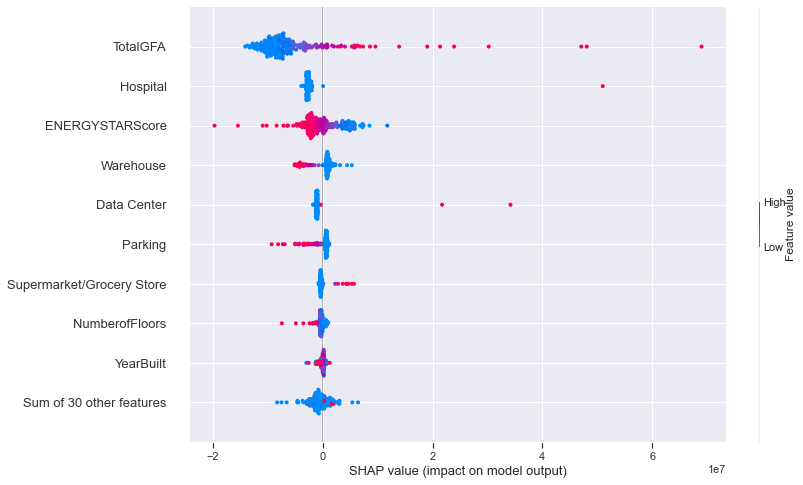

In [43]:
shap.plots.beeswarm(shap_values, plot_size=(12,8), log_scale=False)

On peut en conclure que :
- Plus la valeur de `TotalGFA` est grande, plus cela va faire augmenter la shap value et donc la consommation d'énergie (logique)
- Plus la valeur de `ENERGYSTARScore` est grande et moins le bâtiment consomme d'énergie
- Les hôpitaux et les data center consomment beaucoup d'énergie
- Plus la surface du parking est grande par rapport à la surface totale du bâtiment, moins ce dernier consomme. C'est normal car les parkings ne consomment que très peu d'énergie
- L'âge du bâtiment ne semble pas avoir une forte influence sur sa consommation
- Les entrepôts contribuent avec des shap values négatives, ce qui signifie qu'ils font diminuer la valeur prédite et donc ce sont des bâtiments qui consomment peu

# Sans l'ENERGYSTARScore

## Modélisation

### KNeighborsRegressor

X_train shape : (1262, 20)
X_test shape : (316, 20)
Grid best score: 0.5477991726531422
KNeighborsRegressor(n_neighbors=3, weights='distance')
CV Mean: 0.516
CV Std: 0.164
test score : 0.637


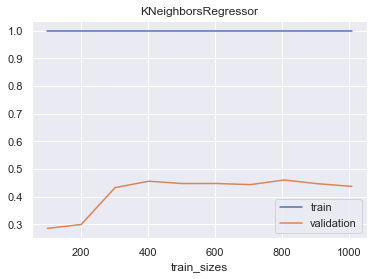

In [44]:
hparams_knr = [{'n_neighbors': np.arange(2, 10, 1), 
            'weights': ['uniform','distance']}]

model_knr = KNeighborsRegressor()

evaluation(df, model_knr, fill=True, hparams=hparams_knr, encoding='ohe',
           select_features=True, n_features=20, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### SGDR

X_train shape : (1262, 15)
X_test shape : (316, 15)
Grid best score: 0.5292160317799237
SGDRegressor(alpha=0.001, random_state=0)
CV Mean: 0.58
CV Std: 0.078
test score : 0.689


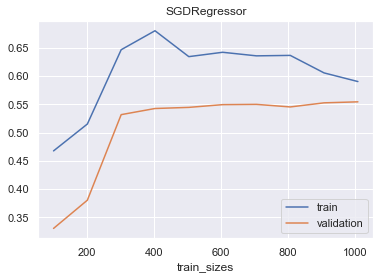

In [45]:
hparams_sgdr = {'penalty': ['l2', 'l1', 'elasticnet'], 
                'alpha': np.logspace(-4, 0, 5),
                #'tol': np.logspace(-3, -1, 3)
            }

model_sgdr = SGDRegressor(random_state=0)

evaluation(df, model_sgdr, hparams=hparams_sgdr, encoding='ohe', scaler=MinMaxScaler(),
           select_features=True, n_features=15, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### SVR

X_train shape : (1262, 43)
X_test shape : (316, 43)
Grid best score: 0.4601176889117985
SVR(C=100000.0, kernel='linear')
CV Mean: 0.476
CV Std: 0.099
test score : 0.581


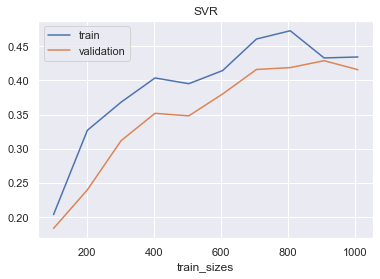

In [46]:
hparams_svr = {'kernel': ['linear', 'rbf'],
            #'gamma': ['auto', 'scale'],
            #'degree': [2,3,4,5],
            'C': [1e3, 1e4, 1e5],
            #'epsilon': np.logspace(-5, -1, 5)
          }

model_svr = SVR()

evaluation(df, model_svr, hparams=hparams_svr, encoding='ohe',
           select_features=False, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### KernelRidge

X_train shape : (1262, 25)
X_test shape : (316, 25)
Grid best score: 0.6457369418140727
KernelRidge(alpha=1.0, degree=2, kernel='poly')
CV Mean: 0.619
CV Std: 0.18
test score : 0.677


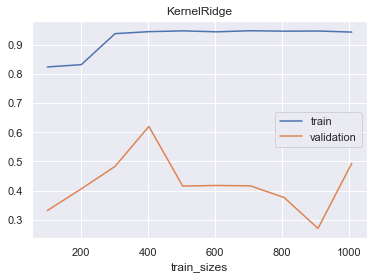

In [47]:
hparams_krr = {'alpha': np.logspace(-2, 2, 5),
               'kernel': ['poly', 'rbf'], 
               'degree': np.arange(2, 5, 1),
               #'gamma': np.logspace(-4, 0, 5)
          }

model_krr = KernelRidge()

evaluation(df, model_krr, hparams=hparams_krr, encoding='ohe',# scaler=MinMaxScaler(),
           select_features=True, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### Random Forest

X_train shape : (1262, 43)
X_test shape : (316, 43)
Grid best score: 0.5436430209554273
RandomForestRegressor(min_samples_leaf=2, n_estimators=10, random_state=0)
CV Mean: 0.648
CV Std: 0.099
test score : 0.69


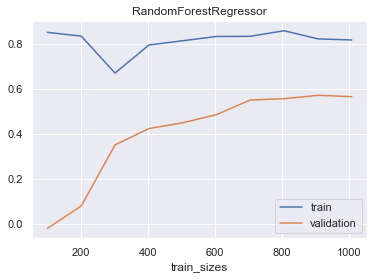

In [48]:
hparams_rfr = {'min_samples_split': np.arange(1,5,1),
               'min_samples_leaf': np.arange(1,5,1)
              }

model_rfr = RandomForestRegressor(n_estimators=10, random_state=0)

evaluation(df, model_rfr, hparams=hparams_rfr, encoding='ohe', scaler=MinMaxScaler(),
           select_features=False, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### Voting

X_train shape : (1262, 43)
X_test shape : (316, 43)
VotingRegressor(estimators=[('SGDR',
                             SGDRegressor(alpha=1.0, penalty='elasticnet',
                                          random_state=0)),
                            ('SVR', SVR(C=100000.0, kernel='linear')),
                            ('Random Forest',
                             RandomForestRegressor(random_state=0))])
CV Mean: 0.614
CV Std: 0.129
test score : 0.688


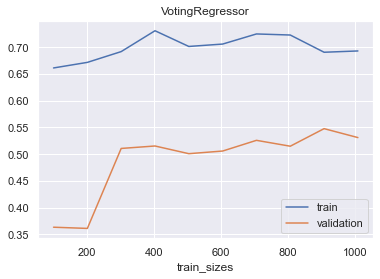

In [49]:
model_knr = KNeighborsRegressor(n_neighbors=4, weights='distance')
model_sgdr = SGDRegressor(alpha=1.0, penalty='elasticnet', random_state=0)
model_svr = SVR(C=1e5, kernel='linear')
model_krr = KernelRidge(alpha=1, degree=2, kernel='poly')
model_rfr = RandomForestRegressor(random_state=0)

voting = VotingRegressor([#('KNN', model_knr),
                         ('SGDR', model_sgdr),
                         ('SVR', model_svr),
                         #('Kernel Ridge', model_krr),
                         ('Random Forest', model_rfr)
                        ])

evaluation(df, voting, hparams=None, encoding='ohe',
           select_features=False, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

### Bagging

X_train shape : (1262, 35)
X_test shape : (316, 35)
Grid best score: 0.597721764291281
BaggingRegressor(max_samples=0.5, n_estimators=50, random_state=0)
CV Mean: 0.65
CV Std: 0.093
test score : 0.587


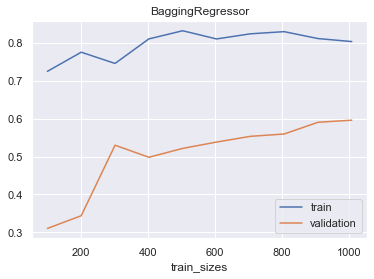

In [50]:
hparams_bag = {'n_estimators': [10, 30, 50],
               'max_samples': [.25, .5, .75, 1.],
               'max_features': [.25, .5, .75, 1.]
              }

bagging = BaggingRegressor(max_samples=0.5, n_estimators=100, random_state=0)

evaluation(df, bagging, hparams=hparams_bag, encoding='ohe',# scaler=MinMaxScaler(),
           select_features=True, n_features=35, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

In [51]:
#estimator = SGDRegressor(alpha=0.001, random_state=0)
#estimator = KernelRidge(alpha=.01, degree=2, kernel='poly')
estimator = KernelRidge(alpha=1.0, degree=2, gamma=0.045, kernel='laplacian')
bagging = BaggingRegressor(base_estimator=estimator, n_estimators=10, random_state=0)

hparams_bag = {#'base_estimator__alpha': np.logspace(-3, 0, 4),
               #'base_estimator__degree': [2, 3, 4],
               'max_features': [.25, .5, .75, 1.],
               'max_samples': [.25, .5, .75, 1.]
              }

evaluation(df, bagging, hparams=hparams_bag, encoding='ohe',
           select_features=True, n_features=25, log_scale=False,
           plot_learning_curve=False, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1262, 25)
X_test shape : (316, 25)
Grid best score: 0.5114903206579774
BaggingRegressor(base_estimator=KernelRidge(alpha=1.0, degree=2, gamma=0.045,
                                            kernel='laplacian'),
                 max_features=0.75, random_state=0)
CV Mean: 0.564
CV Std: 0.157
test score : 0.684


### Boosting

#### AdaBoostRegressor

In [52]:
hparams_abr = {'n_estimators': [10, 50, 100],
               'learning_rate': np.logspace(-2, 2, 5),
               'loss': ['linear', 'square']
              }

adaboost = AdaBoostRegressor(base_estimator=None, n_estimators=100, random_state=0)

evaluation(df, adaboost, hparams=hparams_abr, encoding='ohe',
           select_features=True, n_features=20, log_scale=False,
           plot_learning_curve=False, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1262, 20)
X_test shape : (316, 20)
Grid best score: 0.5553925350853401
AdaBoostRegressor(learning_rate=0.01, loss='square', n_estimators=10,
                  random_state=0)
CV Mean: 0.243
CV Std: 0.415
test score : 0.247


In [53]:
#estimator = SGDRegressor(alpha=0.001, random_state=0)
#estimator = KernelRidge(alpha=.01, degree=2, kernel='poly')
estimator = KernelRidge(alpha=1.0, degree=2, gamma=0.045, kernel='laplacian')
adaboost = AdaBoostRegressor(base_estimator=estimator, n_estimators=10, random_state=0)

hparams_abr = {#'base_estimator__alpha': np.logspace(-3, 0, 4),
               #'base_estimator__degree': [2, 3, 4],
               'learning_rate': np.logspace(-2, 1, 4)
              }

evaluation(df, adaboost, hparams=hparams_abr, encoding='ohe',
           select_features=True, n_features=25, log_scale=False,
           plot_learning_curve=False, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1262, 25)
X_test shape : (316, 25)
Grid best score: 0.5489524501758792
AdaBoostRegressor(base_estimator=KernelRidge(alpha=1.0, degree=2, gamma=0.045,
                                             kernel='laplacian'),
                  n_estimators=10, random_state=0)
CV Mean: 0.578
CV Std: 0.155
test score : 0.701


#### Gradient Boosting

X_train shape : (1262, 25)
X_test shape : (316, 25)
Grid best score: 0.5315725315931282
GradientBoostingRegressor(random_state=0)
CV Mean: 0.657
CV Std: 0.093
test score : 0.469


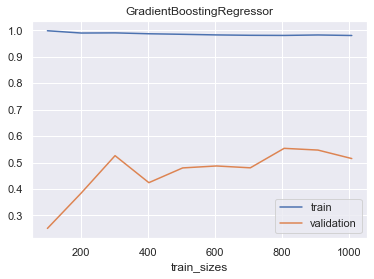

In [54]:
hparams_gbr = {'n_estimators': [10, 50, 100],
               'learning_rate': np.logspace(-3, 0, 4),
               'loss': ['squared_error', 'absolute_error'],
               #'max_depth': [2,3,4],
               #'min_samples_leaf': [3],
               #'tol': np.logspace(-6, -4, 3)
          }

model_gbr = GradientBoostingRegressor(n_estimators=100, random_state=0)

evaluation(df, model_gbr, hparams=hparams_gbr, encoding='ohe',# scaler=MinMaxScaler(),
           select_features=True, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

## Fine tuning du meilleur modèle

X_train shape : (1262, 35)
X_test shape : (316, 35)
RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=10,
                      random_state=0)
CV Mean: 0.648
CV Std: 0.095
test score : 0.634


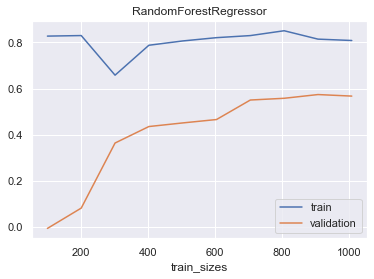

In [55]:
hparams_rfr = {'n_estimators': np.arange(5, 16, 1),
               #'criterion': ["squared_error", "absolute_error", "poisson"],
               #'min_samples_split': np.arange(2, 6, 1),
               #'min_samples_leaf': np.arange(1, 5, 1),
               #'max_features': [10, 20, 30, 40],
               #'n_jobs': [1, 2],
               #'ccp_alpha': [0., .1, .2]
              }

model_rfr = RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=10, random_state=0)

evaluation(df, model_rfr, hparams=None, encoding='ohe', scaler=MinMaxScaler(),
           select_features=True, n_features=35, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1262, 25)
X_test shape : (316, 25)
Grid best score: 0.5353414142951134
KernelRidge(alpha=1.0, degree=2, gamma=0.045, kernel='laplacian')
CV Mean: 0.578
CV Std: 0.163
test score : 0.719


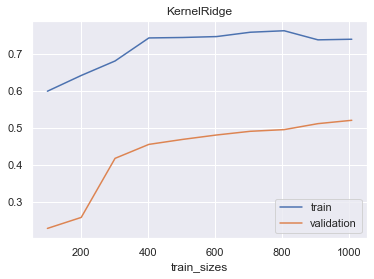

In [56]:
hparams_krr = {#'alpha': np.logspace(-2, 2, 5),
               #'kernel': ['poly', 'laplacian', 'rbf', 'sigmoid'], 
               #'degree': np.arange(2, 5, 1),
               'gamma': np.linspace(0.035, 0.055, 11)
          }

model_krr = KernelRidge(alpha=1.0, degree=2, kernel='laplacian')

evaluation(df, model_krr, hparams=hparams_krr, encoding='ohe',# scaler=MinMaxScaler(),
           select_features=True, n_features=25, log_scale=False,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

X_train shape : (1262, 20)
X_test shape : (316, 20)
BaggingRegressor(max_features=0.75, max_samples=0.5, n_estimators=50,
                 random_state=0)
CV Mean: 0.599
CV Std: 0.101
test score : 0.646


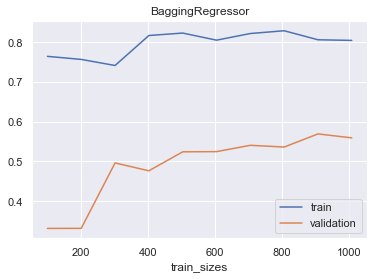

In [57]:
hparams_bag = {#'n_estimators': [10, 30, 50],
               'max_samples': [.45, .5, .55],
               'max_features': [.70, .75, .80]
              }

bagging = BaggingRegressor(max_features=0.75, max_samples=0.5, n_estimators=50, random_state=0)

evaluation(df, bagging, hparams=None, encoding='ohe',# scaler=MinMaxScaler(),
           select_features=True, n_features=20, log_scale=True,
           plot_learning_curve=True, test_size=.2, features_to_drop=['ENERGYSTARScore'])

On voit que les résultats sont moins bons que lorsqu'on prend en compte l'ENERGYSTARScore. C'est normal car on a vu précédemment qu'il faisait parti des variables les plus importantes pour le modèle. Ici, on va prendre la RandomForest car elle présente les meilleurs scores et le moins d'overfitting.

## Feature importance

X_train shape : (1262, 35)
X_test shape : (316, 35)
RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=10,
                      random_state=0)
CV Mean: 0.648
CV Std: 0.095
test score : 0.634


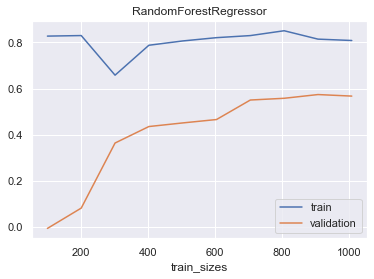

In [58]:
final_model_2 = RandomForestRegressor(min_samples_leaf=2, min_samples_split=5, n_estimators=10, random_state=0)

X_train, X_test, y_train, y_test = evaluation(df, final_model_2, hparams=None, encoding='ohe', 
                                              scaler=MinMaxScaler(),
                                              select_features=True, n_features=35, log_scale=False,
                                              plot_learning_curve=True, test_size=.2, 
                                              features_to_drop=['ENERGYSTARScore'], return_datasets=True)

In [59]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1262, 35) (1262,)
(316, 35) (316,)


### Compilation des shap values

In [60]:
# background data
X_back = shap.utils.sample(X_train, 100)

final_model_2.fit(X_train, y_train)

explainer = shap.Explainer(final_model_2)
shap_values = explainer(X_test)
shap_vals = shap_values.values
base_value = shap_values.base_values[0]

```Python
# Pour sauvegarder les shap values
import pickle
with open('shap_values_target1_2_rfr', 'wb') as fichier:
    mon_pickler = pickle.Pickler(fichier)
    mon_pickler.dump(shap_values)

# Pour les importer
with open('shap_values_target1_2_rfr', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    shap_values = my_depickler.load()
```

On va évaluer la qualité des shap values en calculant le R$^2$ entre les valeurs prédites par le modèles et celles prédites par shap

In [61]:
# Valeurs prédites par le modèle
predictions = final_model_2.predict(X_test)

# Valeurs prédites à partir des shap values
shap_predictions = base_value + shap_vals.sum(axis=1)

# Somme des carrés résiduelle
SSR = ((predictions - shap_predictions)**2).sum()

# Somme des carrés totale
SST = ((predictions - predictions.mean())**2).sum()

R2 = 1 - SSR/SST
R2

1.0

Visualisation graphique

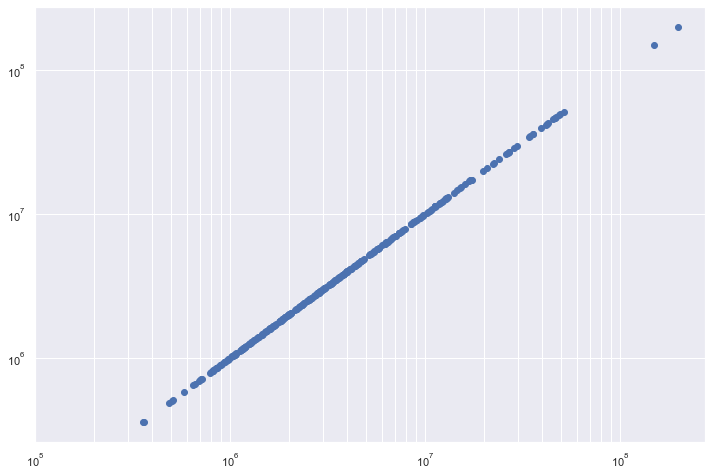

In [62]:
plt.figure(figsize=(12,8))
plt.scatter(predictions, shap_predictions)
plt.xscale('log')
plt.yscale('log')
xticks = (list(np.linspace(1, 9, 9)*1e5) + list(np.linspace(1, 9, 9)*1e6) + list(np.linspace(1, 10, 10)*1e7))
plt.xticks(xticks);

## Influence globale des variables

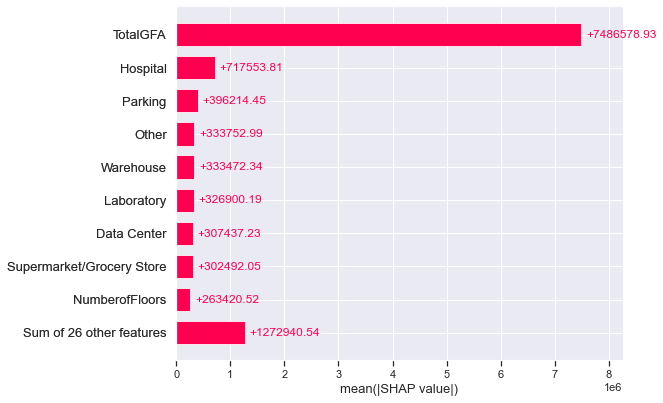

In [63]:
# Moyenne de la valeur absolue des shap values
shap.plots.bar(shap_values, max_display=10)

On voit que la surface du bâtiment représente toujours la variable la plus importante mais qu'en l'absence de l'ENERGYSTARScore, son poids est encore plus grand.

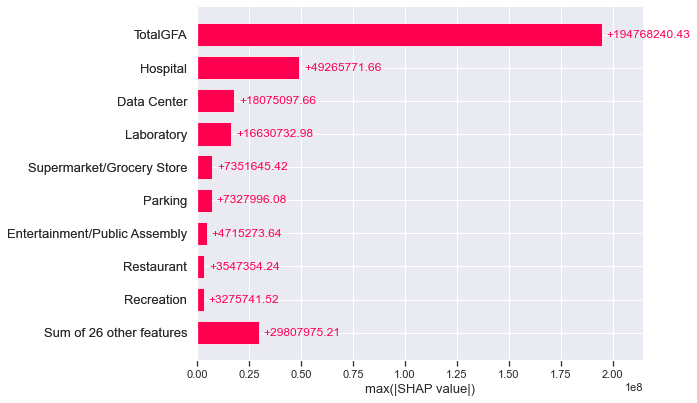

In [64]:
# Valeur maximale de la shap value en valeur absolue
shap.plots.bar(shap_values.abs.max(0))

Les types d'usages les plus impactant ne sont pas les plus nombreux, ce qui montre bien que ce sont ceux qui ont le plus d'impacte sur la consommation (soit ils consomment beaucoup, soit ils consomment peu).

## Influence locale

In [69]:
df_ = df.copy()
merge_property_types(df_)

In [70]:
shap_ind = np.random.randint(0, shap_vals.shape[0])
ind = X_test.iloc[[shap_ind]].index
print(shap_ind)
print(ind.values)
df_.loc[int(ind.values)]

192
[564]


Neighborhood                                            DOWNTOWN
YearBuilt                                                   1999
NumberofFloors                                                 0
LargestPropertyUseType                                      Mall
LargestPropertyUseTypeGFA                               561684.0
SecondLargestPropertyUseType       Entertainment/Public Assembly
SecondLargestPropertyUseTypeGFA                         100000.0
ThirdLargestPropertyUseType                           Restaurant
ThirdLargestPropertyUseTypeGFA                           80000.0
ENERGYSTARScore                                              NaN
SiteEUIWN(kBtu/sf)                                     62.099998
SiteEnergyUseWN(kBtu)                                 46343304.0
Name: 564, dtype: object

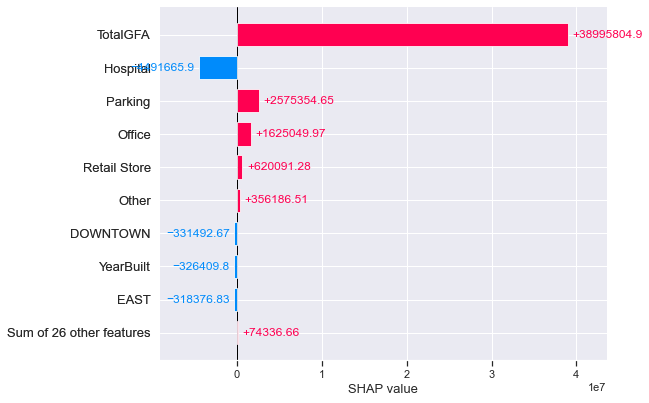

In [71]:
shap.plots.bar(shap_values[shap_ind])

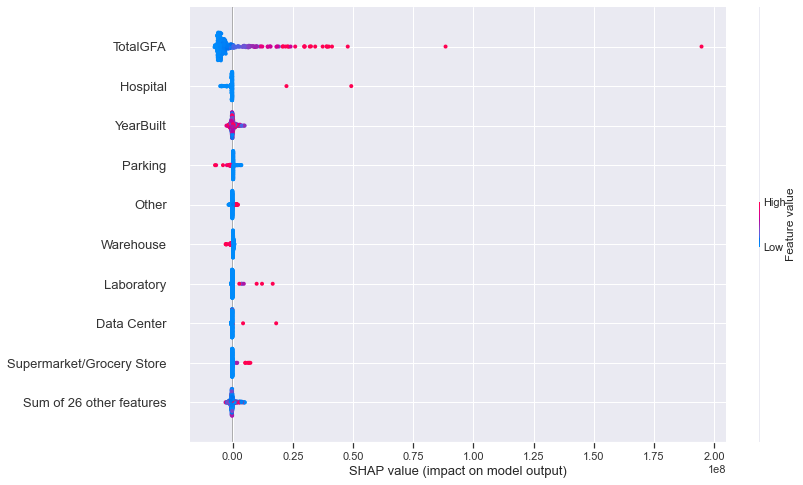

In [79]:
shap.plots.beeswarm(shap_values, plot_size=(12,8))